# Multi-modal deep learning on basketball data


### Explore Datasets

We will use a dataset of scores from US College Basketball tournament games. Dataset has the the seed difference that represents the ranking of how strong the teams are and the score difference of the game (e.g. if team_1 wins by 5 points, the score difference is 5).


In [1]:
import pandas as pd
games_tourney = pd.read_csv("dataset/games_tourney.csv")
print(games_tourney.shape)
games_tourney.head()

(4234, 9)


,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [2]:
games_season = pd.read_csv("dataset/games_season.csv")
print(games_season.shape)
games_season.head()

(312178, 8)


,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


Among these two datasets, `games_season` dataset has the most number of data. We can use this dataset to train a deep learning model and then use that model to see how the model performs in `games_tourney` being the test dataset

### Creating a very simple model


There is an issue with one dataset and that is `seed_diff` feature is not available in `games_season` whereas it is available in `games_tourney`. This is an important feature that represents team strength. In order to get this feature available for `games_season`, we can create a simple regression model using deep learning. This model will be trained with `games_tourney` dataset and then used to produce the missing feature in `games_season` dataset.

In [3]:
# Load layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Input layer
input_tensor = Input(shape=(1,))

# Dense layer
output_layer = Dense(1)

# Connect the dense layer to the input_tensor
output_tensor = output_layer(input_tensor)

# Build the model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')


Let us create a helper function to visualize the model structure and then use it to see the layers in the deep learning model

In [4]:
# Import the plotting function
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

def model_summary(model, model_name):
    # Summarize the model
    model.summary()

    # Plot the model
    plot_model(model, to_file=model_name)

    # Display the image
    data = plt.imread(model_name)
    plt.imshow(data)
    plt.show()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


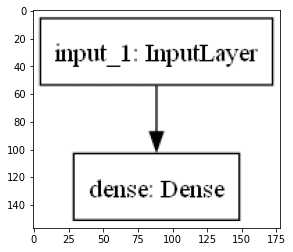

In [5]:
model_summary(model=model, model_name="seed_diff_model.png")



Let us train the model and also evaluate the performance

In [6]:
# Now fit the model
y = games_tourney['seed_diff']
X = games_tourney['score_diff']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=42, test_size=0.2, shuffle=True)
model.fit(X_train, y_train, epochs=25, batch_size=128, validation_split=0.1)

# Evaluate the model on the test data
print(model.evaluate(X_test, y_test))



Epoch 1/25
24/24 [==============================] - 0s 5ms/step - loss: 20.2933 - val_loss: 18.7474
Epoch 2/25
24/24 [==============================] - 0s 1ms/step - loss: 20.0213 - val_loss: 18.4983
Epoch 3/25
24/24 [==============================] - 0s 1ms/step - loss: 19.7498 - val_loss: 18.2509
Epoch 4/25
24/24 [==============================] - 0s 1ms/step - loss: 19.4783 - val_loss: 18.0035
Epoch 5/25
24/24 [==============================] - 0s 1ms/step - loss: 19.2094 - val_loss: 17.7532
Epoch 6/25
24/24 [==============================] - 0s 1ms/step - loss: 18.9370 - val_loss: 17.5091
Epoch 7/25
24/24 [==============================] - 0s 1ms/step - loss: 18.6679 - val_loss: 17.2625
Epoch 8/25
24/24 [==============================] - 0s 1ms/step - loss: 18.3983 - val_loss: 17.0145
Epoch 9/25
24/24 [==============================] - 0s 1ms/step - loss: 18.1280 - val_loss: 16.7665
Epoch 10/25
24/24 [==============================] - 0s 1ms/step - loss: 17.8585 - val_loss: 16.5185

Now we will create the desired `seed_diff` feature for the `games_season` dataset.

In [7]:
games_season["seed_diff"] = model.predict(games_season['score_diff'])
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won,seed_diff
0,1985,3745,6664,0,17,81,64,1,-12.986662
1,1985,126,7493,1,7,77,70,1,-5.347477
2,1985,288,3593,1,7,63,56,1,-5.347477
3,1985,1846,9881,1,16,70,54,1,-12.222743
4,1985,2675,10298,1,12,86,74,1,-9.167069


### Can we create a better `seed_diff` feature?

We can try creating `seed_diff` feature another way by using the two team ids and their performance. Our neural network will take two inputs as team ids and create one regression value `seed_diff` as output. We will now take into account each team's strength. Shared layers allow a model to use the same weight matrix for multiple steps. We will build a "team strength" layer that represents each team by a single number and use this number for both teams in the model. The model will learn a number for each team that works well both when the team is `team_1` and when the team is `team_2` in the input data. 

In [8]:
# Imports
from tensorflow.keras.layers import Embedding, Flatten
from numpy import unique

# Count the unique number of teams
n_teams = unique(games_season["team_1"]).shape[0]

# Create an embedding layer
# team_lookup = Embedding(input_dim=n_teams, output_dim=1, input_length=1, name='Team-Strength')


team_lookup = Embedding(input_dim=n_teams, input_length=1, output_dim=1)

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

Now we will use `team_strength_model` as shared layer and use it to lookup both inputs in the same model. There will be two inputs coming into this shared layer. After completion of processing of the shared layer, the final output will be computed from the subtraction result of two processed inputs in shared layer.

In [9]:
# Imports
from tensorflow.keras.layers import Subtract, Multiply
from tensorflow.keras.models import Model


# Input layer for team 1
team_in_1 = Input(shape=(1,), name="Team-1-In")

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name="Team-2-In")

# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength =  team_strength_model(team_in_2)


# Subtraction layer from previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

Let us visualize the model structure

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Functional (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
subtract (Subtract)             (None, 1)            0           Team-Strength-Model[0]

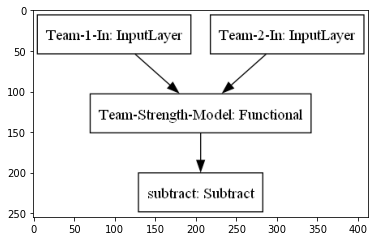

In [10]:
model_summary(model=model, model_name="two_input_seed_diff.png")


We will now use games tournament dataset for training and then use games season dataset for evaluating and comparing with previous model loss

In [11]:
# Get the team_1 column from the regular season data
input_1 = games_tourney["team_1"]

# Get the team_2 column from the regular season data
input_2 = games_tourney["team_2"]

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2], games_tourney["seed_diff"],  epochs=10, batch_size=2048, validation_split=.1, verbose=True)

Epoch 1/10
2/2 [==============================] - 0s 53ms/step - loss: 6.2428 - val_loss: 6.0642
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 6.2402 - val_loss: 6.0641
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 6.2377 - val_loss: 6.0640
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 6.2352 - val_loss: 6.0639
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 6.2327 - val_loss: 6.0638
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 6.2303 - val_loss: 6.0636
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 6.2278 - val_loss: 6.0635
Epoch 8/10
2/2 [==============================] - 0s 7ms/step - loss: 6.2254 - val_loss: 6.0634
Epoch 9/10
2/2 [==============================] - 0s 8ms/step - loss: 6.2229 - val_loss: 6.0633
Epoch 10/10
2/2 [==============================] - 0s 6ms/step - loss: 6.2205 - val_loss: 6.0632


In [12]:
# Get the team_1 column from the regular season data
input_1 = games_season["team_1"]

# Get the team_2 column from the regular season data
input_2 = games_season["team_2"]

model.evaluate([input_1, input_2], games_season["seed_diff"])

9756/9756 [==============================] - 10s 1ms/step - loss: 9.2458


9.24583625793457

In [13]:

# Fit the model to input 1 and 2, using score diff as a target
games_season["seed_diff_2"] = model.predict([input_1, input_2]) 
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won,seed_diff,seed_diff_2
0,1985,3745,6664,0,17,81,64,1,-12.986662,0.015512
1,1985,126,7493,1,7,77,70,1,-5.347477,0.030347
2,1985,288,3593,1,7,63,56,1,-5.347477,0.068499
3,1985,1846,9881,1,16,70,54,1,-12.222743,0.082106
4,1985,2675,10298,1,12,86,74,1,-9.167069,-0.019589


Comparing `seed_diff` and `seed_diff_2` features, we find `seed_diff` more meaningful and we will proceed with `seed_diff` feature for `games_season` dataset in further processes. We will modify the current model and We will now make an input layer for home vs. away after the shared layer. It will now be a 3 input model.


In [14]:
from tensorflow.keras.layers import Input, Concatenate, Dense
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)


# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

We will now train with season data and evaluate with tournament data


In [15]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=10,
          verbose=True,
          validation_split=0.1,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
          games_tourney['score_diff'], verbose=False))




Epoch 1/10
138/138 [==============================] - 0s 2ms/step - loss: 11.9748 - val_loss: 12.4005
Epoch 2/10
138/138 [==============================] - 0s 1ms/step - loss: 11.9294 - val_loss: 12.5596
Epoch 3/10
138/138 [==============================] - 0s 1ms/step - loss: 11.8676 - val_loss: 12.7121
Epoch 4/10
138/138 [==============================] - 0s 1ms/step - loss: 11.7897 - val_loss: 12.8478
Epoch 5/10
138/138 [==============================] - 0s 2ms/step - loss: 11.7029 - val_loss: 12.9488
Epoch 6/10
138/138 [==============================] - 0s 2ms/step - loss: 11.6083 - val_loss: 13.0218
Epoch 7/10
138/138 [==============================] - 0s 2ms/step - loss: 11.5050 - val_loss: 13.0685
Epoch 8/10
138/138 [==============================] - 0s 2ms/step - loss: 11.3947 - val_loss: 13.0916
Epoch 9/10
138/138 [==============================] - 0s 2ms/step - loss: 11.2781 - val_loss: 13.0862
Epoch 10/10
138/138 [==============================] - 0s 1ms/step - loss: 11.1566

Let us visualize the model architecture

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Functional (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
Home-In (InputLayer)            [(None, 1)]          0                                 

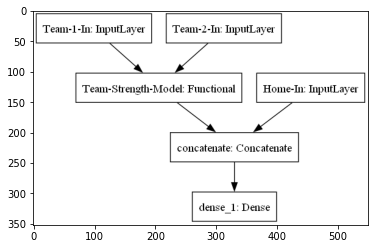

In [16]:
model_summary(model=model, model_name="three_input_score_diff_pred.png")


We will add the model predictions of score difference data as predicted `score_diff` to both dataset so that we can see the comparison.


In [17]:
# Predict
games_tourney['score_diff_pred'] = model.predict([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']])
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,score_diff_pred
0,1985,288,73,0,-3,-9,41,50,0,0.846977
1,1985,5929,73,0,4,6,61,55,1,0.952011
2,1985,9884,73,0,5,-4,59,63,0,1.871663
3,1985,73,288,0,3,9,50,41,1,0.986923
4,1985,3920,410,0,1,-9,54,63,0,1.179645


In [18]:
# Predict
games_season['score_diff_pred'] = model.predict([games_season['team_1'], games_season['team_2'], games_season['home']])
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won,seed_diff,seed_diff_2,score_diff_pred
0,1985,3745,6664,0,17,81,64,1,-12.986662,0.015512,0.690247
1,1985,126,7493,1,7,77,70,1,-5.347477,0.030347,3.015359
2,1985,288,3593,1,7,63,56,1,-5.347477,0.068499,3.040706
3,1985,1846,9881,1,16,70,54,1,-12.222743,0.082106,3.347694
4,1985,2675,10298,1,12,86,74,1,-9.167069,-0.019589,4.537630


Previously we have seen that the error is around 11.85 from real values. We will not use `score_diff_pred` as a substitute for `score_diff`. Instead, we will use it as a transformed feature that will help us in next steps. We will create a neural network model that will take in this feature and will make the model learn the mapping between `score_diff` and `score_diff_pred`.

In [19]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Fit the model
model.fit(games_season[['home', 'seed_diff', 'score_diff_pred']],
          games_season['score_diff'],
          epochs=10,
          verbose=True, validation_split=0.1)


Epoch 1/10
8780/8780 [==============================] - 5s 550us/step - loss: 0.5600 - val_loss: 4.8544e-04
Epoch 2/10
8780/8780 [==============================] - 5s 574us/step - loss: 0.0010 - val_loss: 6.9148e-04
Epoch 3/10
8780/8780 [==============================] - 4s 493us/step - loss: 0.0010 - val_loss: 0.0019
Epoch 4/10
8780/8780 [==============================] - 6s 685us/step - loss: 0.0010 - val_loss: 3.4573e-04
Epoch 5/10
8780/8780 [==============================] - 6s 663us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 6/10
8780/8780 [==============================] - 6s 662us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/10
8780/8780 [==============================] - 6s 701us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 8/10
8780/8780 [==============================] - 6s 670us/step - loss: 0.0010 - val_loss: 3.2806e-04
Epoch 9/10
8780/8780 [==============================] - 7s 800us/step - loss: 0.0011 - val_loss: 1.0480e-04
Epoch 10/10
8780/8780 [=====================

Let us see the structure of this simple model

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


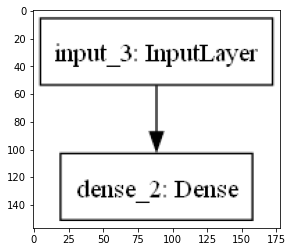

In [20]:
model_summary(model=model, model_name="three_input_score_diff_pred.png")


Let us evaluate the model

In [21]:
# Evaluate the model
print(model.evaluate(games_tourney[['home', 'seed_diff', 'score_diff_pred']],
          games_tourney['score_diff'], verbose=False))

17.751163482666016


We will tweak this model a little so that instead of 1 output, there will be 2 outputs. Now we will increase the last layer's output neuron to 2

In [22]:
# Define the input
input_tensor = Input(shape=(2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


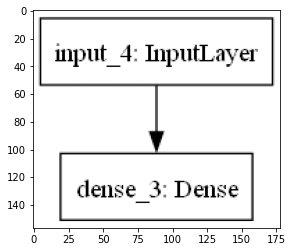

In [23]:
model_summary(model=model, model_name="model4.png")


We will use this model to take 'seed_diff' and 'score_diff' features as inputs and generate regression values for 'score_1' and 'score_2'

In [24]:
# Fit the model
model.fit(games_season[['seed_diff', 'score_diff']],
  		  games_season[['score_1' , 'score_2']],
  		  verbose=True,
  		  epochs=10,
  		  batch_size=16384)

Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 70.9840
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 70.9386
Epoch 3/10
20/20 [==============================] - 0s 1ms/step - loss: 70.8959
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 70.8550
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 70.8158
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 70.7781
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 70.7424
Epoch 8/10
20/20 [==============================] - 0s 1ms/step - loss: 70.7077
Epoch 9/10
20/20 [==============================] - 0s 1ms/step - loss: 70.6743
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 70.6427


In [25]:
# Evaluate the model
model.evaluate(games_tourney[['seed_diff', 'score_diff_pred']],
  		  games_tourney[['score_1' , 'score_2']])


133/133 [==============================] - 0s 469us/step - loss: 71.4818


71.48181915283203